In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure_size = dict(
    ultra=45,
    large=35,
    middle=20,
    small=10,
    very_small=5
)

def set_plt(figsize=(10, 10)):
    params = {'axes.titlesize': figure_size['ultra'],
              'legend.fontsize': figure_size['middle'],
              'figure.figsize': figsize,
              'axes.labelsize': figure_size['ultra'],
              'xtick.labelsize': figure_size['ultra'],
              'ytick.labelsize': figure_size['ultra'],
              'figure.titlesize': figure_size['ultra'],
              'lines.linewidth': figure_size['very_small']}
    plt.rcParams.update(params)

    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)

def set_Border(axes):
    axes.spines['top'].set_color('none')
    axes.spines['right'].set_color('none')
    axes.spines['bottom'].set_color('black')
    axes.spines['left'].set_color('black')
    axes.spines['bottom'].set_linewidth(figure_size['very_small'])
    axes.spines['left'].set_linewidth(figure_size['very_small'])
    axes.tick_params(axis='both', width=figure_size['very_small'], length=figure_size['small'])


COLORS = [
    (0, 159/255, 232/255),
    (222/255, 28/255, 38/255),
    (0, 191/255, 82/255),
    (255/255, 122/255, 23/255)
]

In [3]:
Homo_sapiens_GRCh38_file = '/data1/lmh_data/MINE/source/Homo_sapiens.GRCh38.84.gtf'
Homo_sapiens_GRCh38 = dict()
with open(Homo_sapiens_GRCh38_file, 'r')as f:
    for line in f:
        datas = line.strip().split()
        if len(datas) < 4:
            continue
        if datas[2] != "gene":
            continue
        gene_id = datas[9].split('"')[1]
        Homo_sapiens_GRCh38[gene_id] = [datas[0], int(datas[3]), int(datas[4])]

def get_rna_infos(RNA_seq_file, column_name):
    rna_infos = pd.read_csv(RNA_seq_file)
    rna_infos["rna_count"] = rna_infos[column_name]
    rna_infos = rna_infos.loc[rna_infos["rna_count"]>0]
    rna_infos.insert(rna_infos.shape[1], 'Chromosome', '')
    rna_infos.insert(rna_infos.shape[1], 'Gene start (bp)', 0)
    rna_infos.insert(rna_infos.shape[1], 'Gene end (bp)', 0)
    for index in rna_infos.index:
        if rna_infos.loc[index]["ID"] not in Homo_sapiens_GRCh38.keys():
            continue
        data = Homo_sapiens_GRCh38[rna_infos.loc[index]["ID"]]
        rna_infos.loc[index, "Chromosome"] = data[0]
        rna_infos.loc[index, "Gene start (bp)"] = data[1]
        rna_infos.loc[index, "Gene end (bp)"] = data[2]
    return rna_infos

control_rna_infos = get_rna_infos(
    '/data1/lmh_data/MINE/source/HeLa/GSM5739831_raw_count_WT_NHS_Rep1.csv', 'WT_NHS_Rep1'
)
Hex_rna_infos = get_rna_infos(
    '/data1/lmh_data/MINE/source/HeLa/GSM5739827_raw_count_WT_HS_Hex_Rep1.csv', 'WT_HS_Hex_Rep1'
)

In [4]:
def add_gene_infos(infos, rna_infos):
    for index in infos.index:
        _chr, _start, _end = infos.loc[index][0], infos.loc[index][1], infos.loc[index][2]
        temp = rna_infos.loc[rna_infos["Chromosome"]==_chr[3:]]
        temp = temp.loc[temp["Gene start (bp)"]>=_start].loc[temp["Gene end (bp)"]<=_end]
        result = temp[["rna_count"]].mean()
#         infos.loc[index, "RNA_rpkms"] = math.log(result["rna_rpkms_avg"], 2)
        infos.loc[index, "rna_count"] = result["rna_count"]
        infos.loc[index, "rna_count/control_Volume"] = result["rna_count"] / infos.loc[index, "control_Volume"]
        infos.loc[index, "rna_count/Hex_Volume"] = result["rna_count"] / infos.loc[index, "Hex_Volume"]
    return infos

[ 0.20812322 -1.23932216]


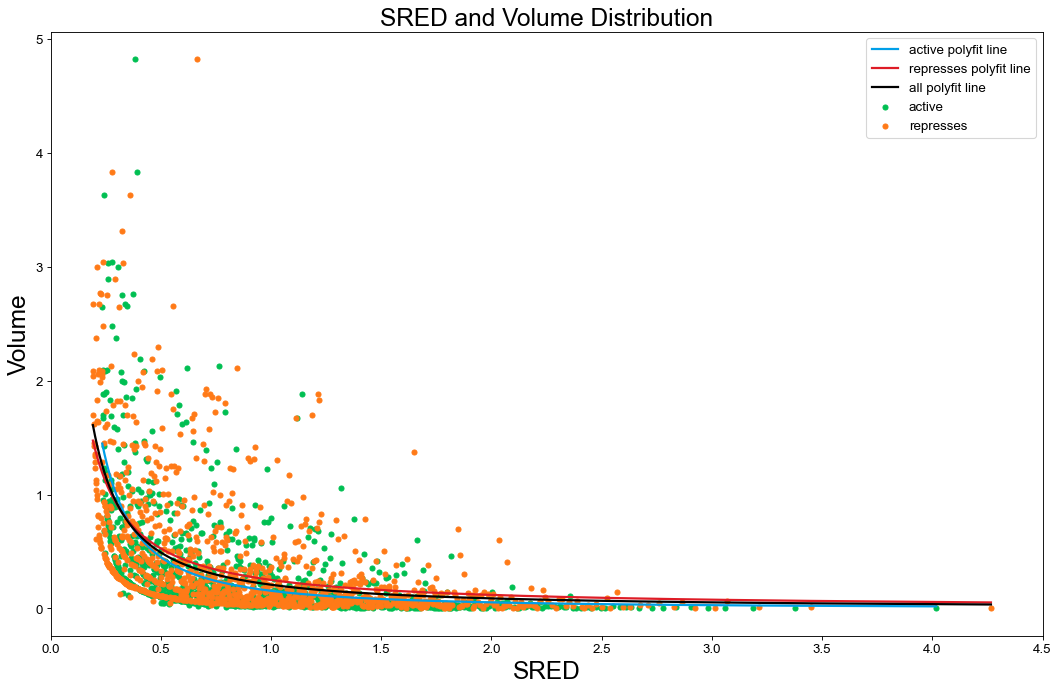

[ 0.83870843 -0.10504843]


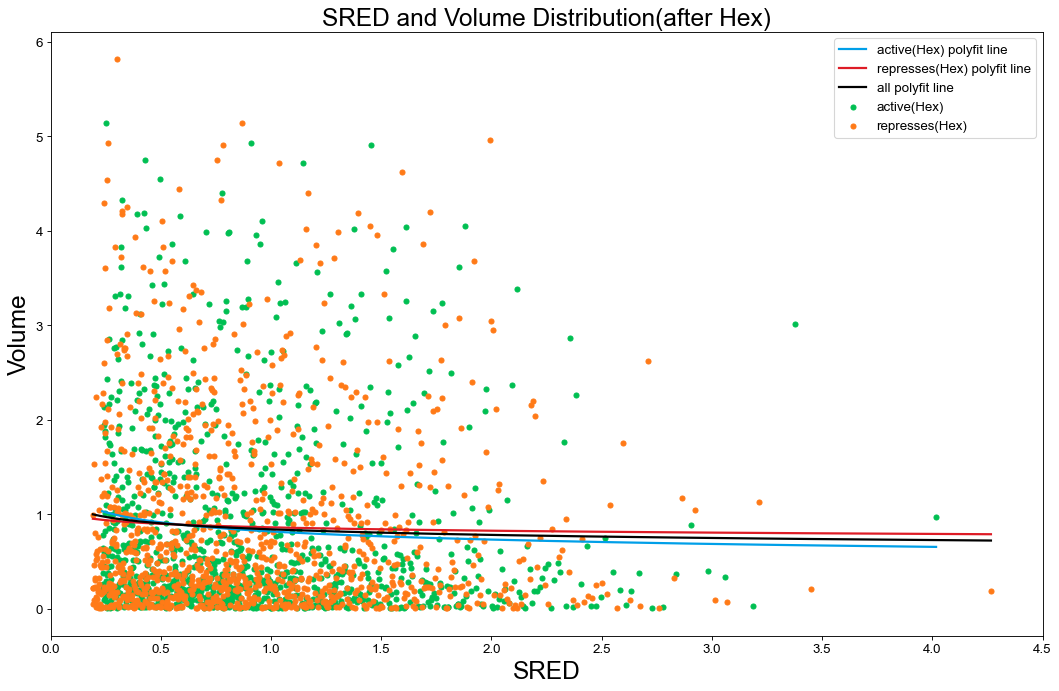

In [5]:
active_SDOC_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HeLa_ATAC_H3K27ac_H3K4me3/experiment/SDOC/result/HeLa_SDOC.tsv'
represses_SDOC_path = '/data1/lmh_data/MINE/GM12878_H3K9me3_H3K27me3/analyse/HeLa_H3K9me3_H3K27me3/experiment/SDOC/result/HeLa_SDOC.tsv'
Hex_SDOC_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HeLa_ATAC_H3K27ac_H3K4me3/experiment/SDOC_GSE138543_Hex5/result/HeLa_SDOC.tsv'

active_infos = pd.read_csv(active_SDOC_path, sep="\t", header=None)
represses_infos = pd.read_csv(represses_SDOC_path, sep="\t", header=None)
Hex_infos = pd.read_csv(Hex_SDOC_path, sep="\t", header=None)

def show(df, title, colors):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (10, 10),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)
    
    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)
    
    # Prepare Data 
    categories = np.unique(df['Category'])

    # Draw Plot for Each Category
    fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

    for i, category in enumerate(categories):
        plt.scatter('SRED', 'Volume', data=df.loc[df.Category==category, :], s=20, color=colors[category], label=str(category))
    
    def target_func(x, a, b):
        return a * (x ** b)
    
    data = df.loc[df.SRED>0, :].copy()
    data.sort_values('SRED', inplace=True)
    for i, category in enumerate(categories):
        _data = data.loc[data.Category==category, :]
        _color = COLORS[0] if category[:6] == 'active' else COLORS[1]
        popt, pcov = curve_fit(target_func, _data.SRED.values, _data.Volume.values, maxfev=50000000)
        calc_ydata = [target_func(i, popt[0], popt[1]) for i in _data.SRED.values]
        plt.plot(_data.SRED.values, calc_ydata, color=_color, label='{} polyfit line'.format(category))
    
    popt, pcov = curve_fit(target_func, data.SRED.values, data.Volume.values, maxfev=50000000)
    calc_ydata = [target_func(i, popt[0], popt[1]) for i in data.SRED.values]
    plt.plot(data.SRED.values, calc_ydata, 'black', label='all polyfit line')
    print(popt)
    
    # Decorations
    plt.gca().set(xlim=(0, 4.5), xlabel='SRED', ylabel='Volume')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=22)
    plt.legend(fontsize=12)
    plt.show()

_colors = {
    'active': COLORS[2],
    'represses': COLORS[3],
    'active(Hex)': COLORS[2],
    'represses(Hex)': COLORS[3],
}

active_infos['Category'] = 'active'
active_infos['Volume'] = active_infos.loc[:, 4]
active_infos['SRED'] = active_infos.loc[:, 5]

represses_infos['Category'] = 'represses'
represses_infos['Volume'] = represses_infos.loc[:, 4]
represses_infos['SRED'] = represses_infos.loc[:, 5]

show(pd.concat([active_infos, represses_infos], axis=0), 'SRED and Volume Distribution', _colors)

Hex_active_infos = Hex_infos.copy()
Hex_active_infos['Category'] = 'active(Hex)'
Hex_active_infos['Volume'] = Hex_active_infos.loc[:, 4]
Hex_active_infos['Hex_Volume'] = Hex_active_infos['Volume']
Hex_active_infos['control_Volume'] = active_infos['Volume']
Hex_active_infos['SRED'] = active_infos['SRED']

Hex_represses_infos = Hex_infos.copy()
Hex_represses_infos['Category'] = 'represses(Hex)'
Hex_represses_infos['Volume'] = Hex_represses_infos.loc[:, 4]
Hex_represses_infos['Hex_Volume'] = Hex_represses_infos['Volume']
Hex_represses_infos['control_Volume'] = represses_infos['Volume']
Hex_represses_infos['SRED'] = represses_infos['SRED']

show(pd.concat([Hex_active_infos, Hex_represses_infos], axis=0), 'SRED and Volume Distribution(after Hex)', _colors)

0.935602370037778


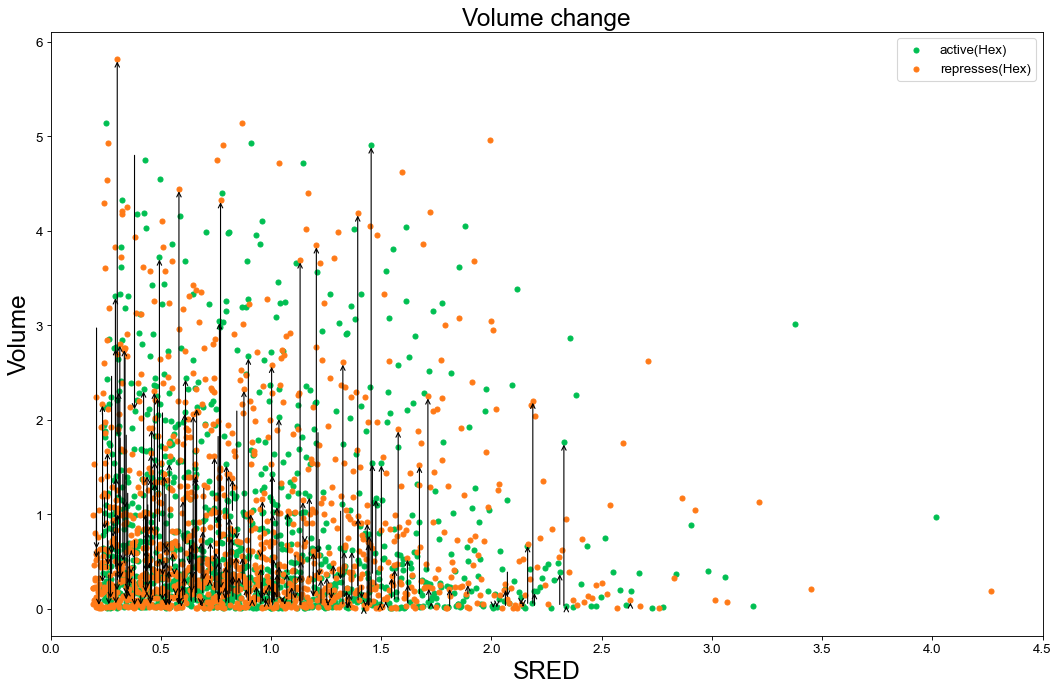

In [6]:
def show(df, title, colors):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (10, 10),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)
    
    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)
    
    # Prepare Data 
    categories = np.unique(df['Category'])

    # Draw Plot for Each Category
    fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

    for i, category in enumerate(categories):
        plt.scatter(
            'SRED', 'Volume', data=df.loc[df.Category==category, :],
            s=20, color=colors[category], label=str(category)
        )
    
    _df = df.loc[df.SRED>0, :].copy()
    print(_df['SRED'].mean())
    _df = _df.sample(frac=0.1)
    for index in _df.index.tolist():
        plt.annotate(
            text="", 
            xy=(float(_df.loc[index, "SRED"]), float(_df.loc[index, "Volume"])),
            xytext=(float(_df.loc[index, "SRED"]), float(_df.loc[index, "control_Volume"])),
            arrowprops={"arrowstyle":"->"}
        )
    # Decorations
    plt.gca().set(xlim=(0, 4.5), xlabel='SRED', ylabel='Volume')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=22)
    plt.legend(fontsize=12)
    plt.show()

show(pd.concat([Hex_active_infos, Hex_represses_infos], axis=0).reset_index(drop=True), 'Volume change', _colors)

No handles with labels found to put in legend.


0.563861393631908
0.573295145714328
0.574433286523869
0.575392035157866
0.576336287578704
0.577545834336929
0.580512161452138
0.581781579610927
0.582889939522094
0.586509033201086
0.587317524508211
0.59966769095557


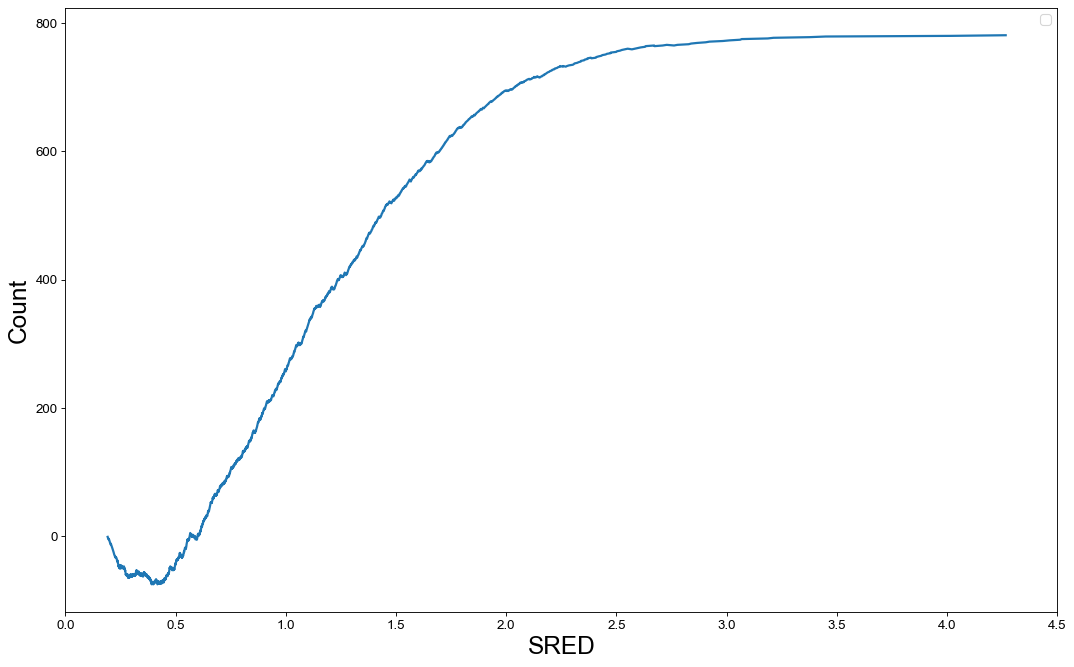

In [7]:
def show(df):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (10, 10),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)
    
    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)
    
    # Prepare Data 
    categories = np.unique(df['Category'])

    # Draw Plot for Each Category
    fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
    
    x, y = [], []
    nums = 0
    _df = df.loc[df.SRED>0, :].copy()
    _df = _df.sort_values('SRED', ascending=True)
    for index in _df.index.tolist():
        if float(_df.loc[index, "control_Volume"]) < float(_df.loc[index, "Volume"]):
            nums += 1
        else:
            nums -= 1
        if nums == 0:
            print(float(_df.loc[index, "SRED"]))
        y.append(nums)
        x.append(float(_df.loc[index, "SRED"]))
    plt.plot(x, y)
    
    plt.gca().set(xlim=(0, 4.5), xlabel='SRED', ylabel='Count')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#     plt.title(title, fontsize=22)
    plt.legend(fontsize=12)
    plt.show()

show(pd.concat([Hex_active_infos, Hex_represses_infos], axis=0).reset_index(drop=True))

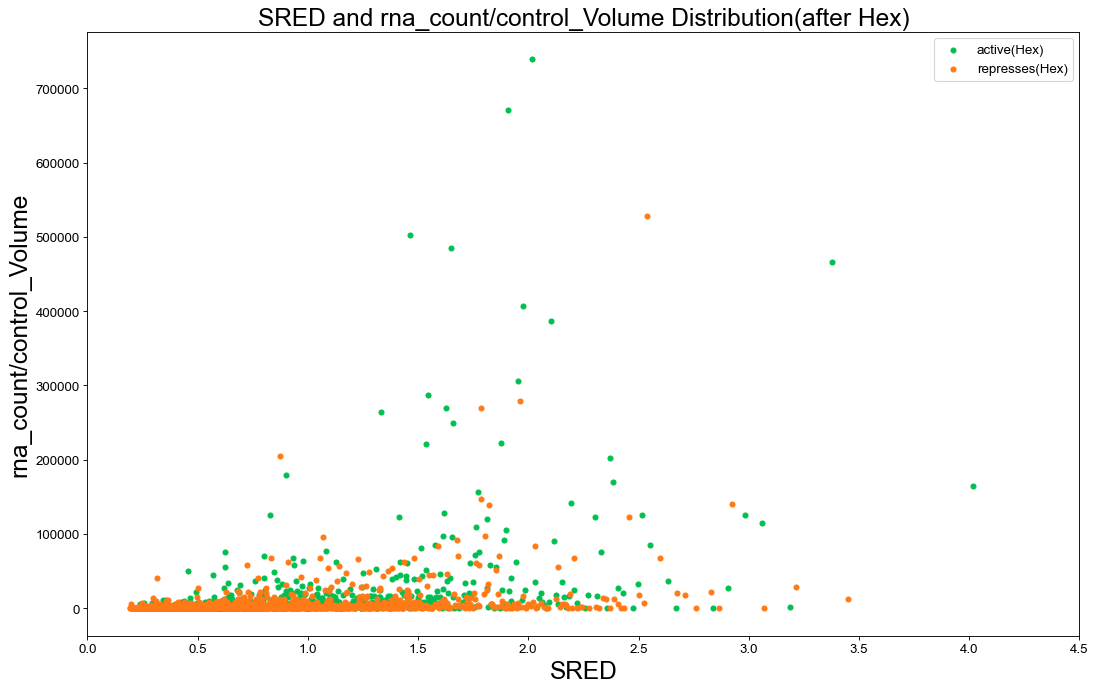

In [8]:
df = pd.concat([Hex_active_infos, Hex_represses_infos], axis=0).reset_index(drop=True)
df = df.loc[df.SRED>0, :].copy()
df['control_Volume-Hex_Volume'] = df['control_Volume'] - df['Hex_Volume']
df = add_gene_infos(df, control_rna_infos)

def show(df, title, colors):
    very_large = 24; large = 22; med = 16; small = 12
    params = {'axes.titlesize': very_large,
              'legend.fontsize': med,
              'figure.figsize': (10, 10),
              'axes.labelsize': large,
              'axes.titlesize': large,
              'xtick.labelsize': large,
              'ytick.labelsize': large,
              'figure.titlesize': very_large,
              'lines.linewidth': 2}
    plt.rcParams.update(params)
    
    font = {'family': 'sans-serif', 'sans-serif': 'Arial'}
    plt.rc('font', **font)
    
    # Prepare Data 
    categories = np.unique(df['Category'])

    # Draw Plot for Each Category
    fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

    for i, category in enumerate(categories):
        plt.scatter('SRED', 'rna_count/control_Volume', data=df.loc[df.Category==category, :], s=20, color=colors[category], label=str(category))
    
    # Decorations
    plt.gca().set(xlim=(0, 4.5), xlabel='SRED', ylabel='rna_count/control_Volume')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title, fontsize=22)
    plt.legend(fontsize=12)
    plt.show()

show(df, 'SRED and rna_count/control_Volume Distribution(after Hex)', _colors)


In [9]:
_1 = df.loc[df.SRED<0.6, :].copy()
_1 = _1.sort_values('control_Volume-Hex_Volume', ascending=True)
print(_1.loc[_1['control_Volume-Hex_Volume']<0, :][["rna_count/control_Volume"]].mean())
print(_1.loc[_1['control_Volume-Hex_Volume']>0, :][["rna_count/control_Volume"]].mean())
_1

rna_count/control_Volume    2706.404363
dtype: float64
rna_count/control_Volume    949.035348
dtype: float64


,0,1,2,3,4,5,Category,Volume,Hex_Volume,control_Volume,SRED,control_Volume-Hex_Volume,rna_count,rna_count/control_Volume,rna_count/Hex_Volume
374,chr10,104360000,109870000,56,4.751924,-0.186177,active(Hex),4.751924,4.751924,0.142487,0.427144,-4.609436,198.750000,1394.859414,41.825165
1274,chr2,20650000,27690000,96,4.546948,0.384096,active(Hex),4.546948,4.546948,0.103899,0.497895,-4.443049,722.816901,6956.940070,158.967498
3974,chr2,158010000,164730000,64,4.442528,0.020995,represses(Hex),4.442528,4.442528,0.081868,0.582216,-4.360660,555.305556,6782.896500,124.997636
1149,chr18,36820000,45660000,66,5.144059,-0.104132,active(Hex),5.144059,5.144059,0.904706,0.252688,-4.239352,1440.227273,1591.928161,279.978789
2296,chr7,117130000,120950000,18,4.160073,-0.988359,active(Hex),4.160073,4.160073,0.136044,0.587318,-4.024029,392.428571,2884.572496,94.332138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,chr13,78130000,79550000,5,2.086881,-1.205579,active(Hex),2.086881,2.086881,4.822833,0.380707,2.735951,NaN,NaN,NaN
1888,chr4,152780000,153130000,2,0.180340,-0.248170,active(Hex),0.180340,0.180340,3.040820,0.278900,2.860479,296.000000,97.342169,1641.340583
4473,chr4,152780000,153130000,2,0.180340,-0.248170,represses(Hex),0.180340,0.180340,3.040820,0.236444,2.860479,296.000000,97.342169,1641.340583
1154,chr18,48470000,48670000,4,0.167941,0.493716,active(Hex),0.167941,0.167941,3.830052,0.391914,3.662111,1143.250000,298.494646,6807.455307


In [10]:
df.loc[df.SRED>0.6, :].copy()

,0,1,2,3,4,5,Category,Volume,Hex_Volume,control_Volume,SRED,control_Volume-Hex_Volume,rna_count,rna_count/control_Volume,rna_count/Hex_Volume
2,chr1,5990000,6700000,31,0.685238,1.114187,active(Hex),0.685238,0.685238,0.112054,1.092796,-0.573184,391.000000,3489.385049,570.604769
4,chr1,7650000,7970000,6,0.224762,0.613618,active(Hex),0.224762,0.224762,0.035545,1.292355,-0.189218,247.800000,6971.540696,1102.499407
7,chr1,8360000,9200000,20,0.391518,1.218418,active(Hex),0.391518,0.391518,0.130238,0.798996,-0.261280,5252.000000,40326.276117,13414.455706
8,chr1,9200000,9260000,3,0.008814,2.712931,active(Hex),0.008814,0.008814,0.002930,1.420949,-0.005884,NaN,NaN,NaN
10,chr1,9620000,10510000,21,0.342069,1.375199,active(Hex),0.342069,0.342069,0.151960,1.057156,-0.190109,591.000000,3889.168923,1727.721486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5130,chr9,120620000,121200000,1,1.989060,-1.334301,represses(Hex),1.989060,1.989060,0.189615,0.758332,-1.799445,3.000000,15.821573,1.508250
5150,chr9,130460000,130690000,10,0.189757,1.252566,represses(Hex),0.189757,0.189757,0.053122,0.969893,-0.136635,460.500000,8668.663894,2426.783346
5156,chr9,131750000,132410000,13,0.623330,0.372636,represses(Hex),0.623330,0.623330,0.091272,0.896723,-0.532058,33.750000,369.773991,54.144676
5157,chr9,132410000,133490000,17,1.310798,-0.096777,represses(Hex),1.310798,1.310798,0.170958,0.696249,-1.139840,608.166667,3557.409434,463.966778


In [11]:
_2 = df.loc[df.SRED>0.6, :].copy()
_2 = _2.sort_values('control_Volume-Hex_Volume', ascending=True)
print(_2.loc[_2['control_Volume-Hex_Volume']<0, :][["rna_count/control_Volume"]].mean())
print(_2.loc[_2['control_Volume-Hex_Volume']>0, :][["rna_count/control_Volume"]].mean())
_2

rna_count/control_Volume    20549.465295
dtype: float64
rna_count/control_Volume    4227.052358
dtype: float64


,0,1,2,3,4,5,Category,Volume,Hex_Volume,control_Volume,SRED,control_Volume-Hex_Volume,rna_count,rna_count/control_Volume,rna_count/Hex_Volume
3376,chr14,81460000,87930000,17,4.963861,-1.093570,represses(Hex),4.963861,4.963861,0.059330,1.991297,-4.904530,30.000000,505.643786,6.043683
2121,chr6,90590000,97060000,13,4.928691,-1.192511,active(Hex),4.928691,4.928691,0.050819,0.907852,-4.877873,744.850000,14657.039904,151.125305
5075,chr9,77160000,83590000,58,4.906473,-0.180233,represses(Hex),4.906473,4.906473,0.044524,0.779813,-4.861949,699.451613,15709.551532,142.556909
2490,chr9,77160000,83590000,58,4.906473,-0.180233,active(Hex),4.906473,4.906473,0.044524,1.454143,-4.861949,699.451613,15709.551532,142.556909
2959,chr10,104360000,109870000,56,4.751924,-0.186177,represses(Hex),4.751924,4.751924,0.142487,0.756895,-4.609436,198.750000,1394.859414,41.825165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,chr6,56850000,56900000,1,0.007716,1.901412,active(Hex),0.007716,0.007716,1.675990,1.116037,1.668274,NaN,NaN,NaN
4687,chr6,56850000,56900000,1,0.007716,1.901412,represses(Hex),0.007716,0.007716,1.675990,1.112778,1.668274,NaN,NaN,NaN
2986,chr11,11790000,12040000,9,0.073177,1.839047,represses(Hex),0.073177,0.073177,1.859120,0.733476,1.785943,91.333333,49.127186,1248.112966
1910,chr5,10250000,10450000,7,0.176465,0.965715,active(Hex),0.176465,0.176465,2.130082,0.764520,1.953617,NaN,NaN,NaN


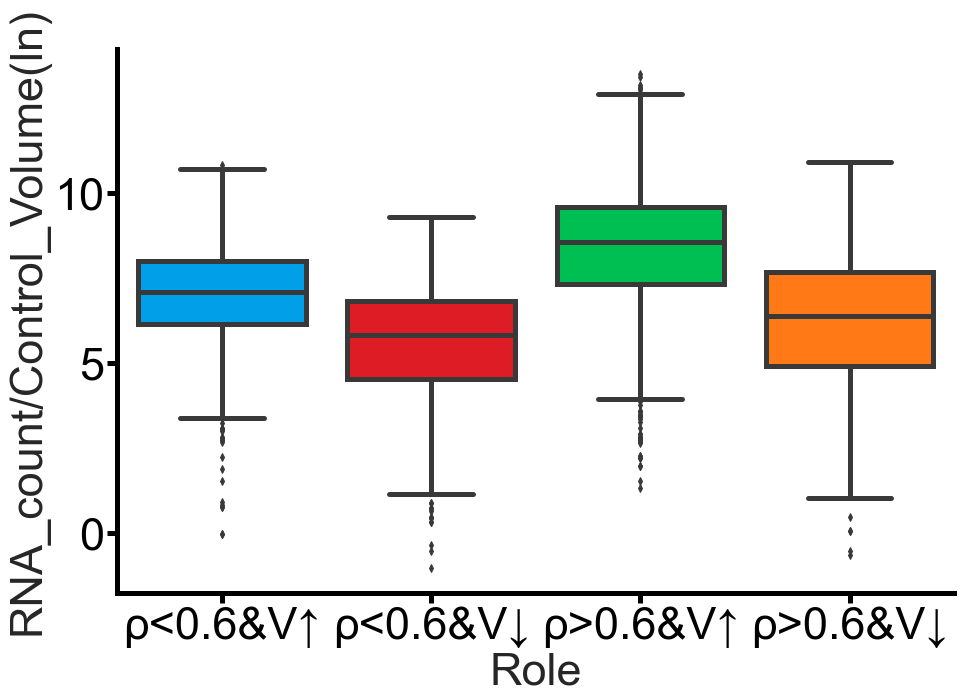

In [12]:
ll = _1.loc[_1['control_Volume-Hex_Volume']<0].copy()
lh = _1.loc[_1['control_Volume-Hex_Volume']>0].copy()
hl = _2.loc[_2['control_Volume-Hex_Volume']<0].copy()
hh = _2.loc[_2['control_Volume-Hex_Volume']>0].copy()

ll["role"] = "ρ<0.6&V↑"
lh["role"] = "ρ<0.6&V↓"
hl["role"] = "ρ>0.6&V↑"
hh["role"] = "ρ>0.6&V↓"

ll["ln(rna_count/control_Volume)"] = np.log(ll["rna_count/control_Volume"])
lh["ln(rna_count/control_Volume)"] = np.log(lh["rna_count/control_Volume"])
hl["ln(rna_count/control_Volume)"] = np.log(hl["rna_count/control_Volume"])
hh["ln(rna_count/control_Volume)"] = np.log(hh["rna_count/control_Volume"])

df = pd.concat([ll, lh, hl, hh])

my_pal = {
    "ρ<0.6&V↑": COLORS[0],
    "ρ<0.6&V↓": COLORS[1],
    "ρ>0.6&V↑": COLORS[2],
    "ρ>0.6&V↓": COLORS[3]
}

set_plt(figsize=(15, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x="role", y="ln(rna_count/control_Volume)", data=df,
    palette=my_pal, saturation=1, linewidth=figure_size['very_small']
)

sns.despine()
set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
# plt.xticks(rotation=10)
plt.grid(False)

plt.xlabel("Role", fontsize=figure_size['ultra'])
plt.ylabel("RNA_count/Control_Volume(ln)", fontsize=figure_size['ultra'])
# plt.title('gene expression in active region', fontsize=figure_size['ultra'])

# plt.savefig('figure_file/The relationship between RNA and SRED(active).pdf', format='pdf', bbox_inches='tight')
plt.show()

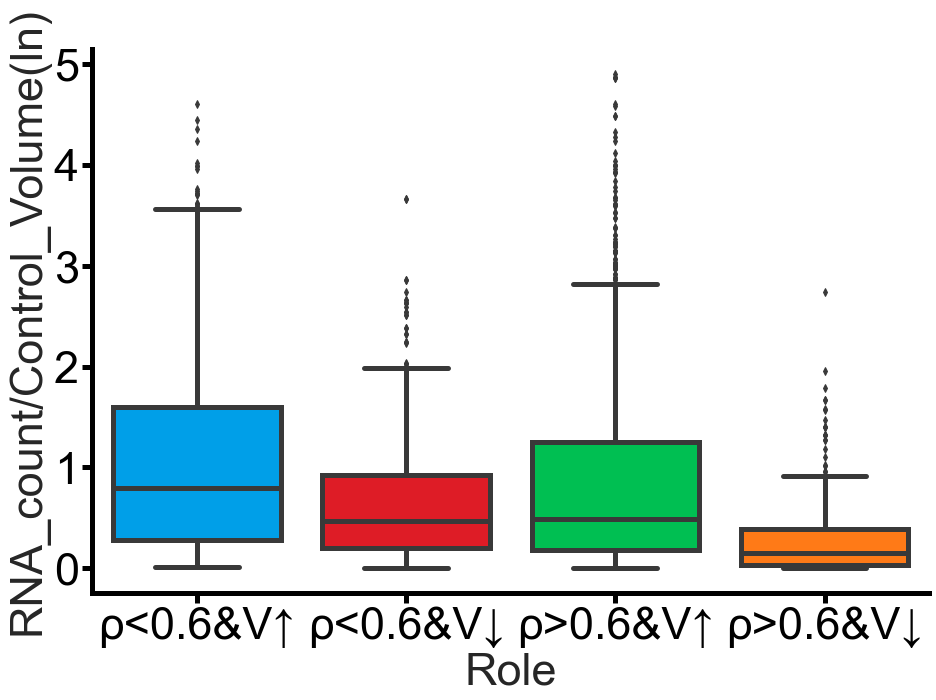

In [13]:
ll = _1.loc[_1['control_Volume-Hex_Volume']<0].copy()
lh = _1.loc[_1['control_Volume-Hex_Volume']>0].copy()
hl = _2.loc[_2['control_Volume-Hex_Volume']<0].copy()
hh = _2.loc[_2['control_Volume-Hex_Volume']>0].copy()

ll["role"] = "ρ<0.6&V↑"
lh["role"] = "ρ<0.6&V↓"
hl["role"] = "ρ>0.6&V↑"
hh["role"] = "ρ>0.6&V↓"

ll["abs(control_Volume-Hex_Volume)"] = abs(ll["control_Volume-Hex_Volume"])
lh["abs(control_Volume-Hex_Volume)"] = abs(lh["control_Volume-Hex_Volume"])
hl["abs(control_Volume-Hex_Volume)"] = abs(hl["control_Volume-Hex_Volume"])
hh["abs(control_Volume-Hex_Volume)"] = abs(hh["control_Volume-Hex_Volume"])

df = pd.concat([ll, lh, hl, hh])

my_pal = {
    "ρ<0.6&V↑": COLORS[0],
    "ρ<0.6&V↓": COLORS[1],
    "ρ>0.6&V↑": COLORS[2],
    "ρ>0.6&V↓": COLORS[3]
}

set_plt(figsize=(15, 10))
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x="role", y="abs(control_Volume-Hex_Volume)", data=df,
    palette=my_pal, saturation=1, linewidth=figure_size['very_small']
)

sns.despine()
set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
# plt.xticks(rotation=10)
plt.grid(False)

plt.xlabel("Role", fontsize=figure_size['ultra'])
plt.ylabel("RNA_count/Control_Volume(ln)", fontsize=figure_size['ultra'])
# plt.title('gene expression in active region', fontsize=figure_size['ultra'])

plt.savefig('figure_file/Volume changes for different role.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [14]:
_ranges = {
     # SRED<0.6 & control Volume << Hex Volume
    '374': [10, 104360, 109870],
    '1274': [2, 20650, 27690],
    '3974': [2, 158010, 164730],
    '1149': [18, 36820, 45660],
    '2296': [7, 117130, 120950],
     # SRED<0.6 & control Volume >> Hex Volume
    '3739': [18, 48470, 48670],
    '4473': [4, 152780, 153130],
    '698': [13, 78130, 79550],
     # SRED>=0.6 & control Volume << Hex Volume
    '3376': [14, 81460, 87930],
    '2121': [6, 90590, 97060],
    '5075': [9, 77160, 83590],
    '2959': [10, 104360, 109870],
     # SRED>=0.6 & control Volume >> Hex Volume
    '3283': [13, 78130, 79550],
    '1910': [5, 10250, 10450],
    '2986': [11, 11790, 12040],
    '4687': [6, 56850, 56900],
}

In [15]:
# enhanced loop
HeLa_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig = np.load(
    '/home/lmh/work/repos/MINE/analyse/fig3/tss/temp/HeLa_ATAC_H3K27ac_H3K4me3_2_100_all_enhanced_sig.npy',
    allow_pickle=True
).item()
HeLa_H3K9me3_H3K27me3_2_100_all_enhanced_sig = np.load(
    '/home/lmh/work/repos/MINE/analyse/fig3/represses/tss/temp/HeLa_H3K9me3_H3K27me3_2_100_all_enhanced_sig.npy',
    allow_pickle=True
).item()

# seq file path
auxiliary_files_path = '/data1/lmh_data/MINE/source'
CTCF_path = os.path.join(auxiliary_files_path, 'HeLa', 'CTCF_peaks.bed')

Hex_CTCF_path = os.path.join(auxiliary_files_path, 'GSE138543', 'GSE138543_ChIPseq_CTCF_peaks.Hex5.bed')

In [16]:
def get_score(sigs, _chr, _start, _end):
    length = int((_end - _start) / 10 + 1)
    scores = np.zeros(length)
    for loop in sigs[_chr]:
        for anchor in loop:
            if anchor >= _start and anchor < _end + 10:
                scores[int((anchor-_start)/10)] += 1
    return scores

def get_seq_score(chip_seq_path, _chr, _start, _end):
    length = int((_end - _start) / 10 + 1)
    scores = np.zeros(length)
    with open(chip_seq_path)as f:
        for line in f:
            datas = line.strip().split()
            left, right = int(int(datas[1])/1000), int(int(datas[2])/1000)
            if left >= _start and right < _end + 10:
                scores[int((left-_start)/10)] += 1
    return scores

In [17]:
active_PASTIS_out_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HeLa_ATAC_H3K27ac_H3K4me3/experiment/SDOC/result/HeLa/PASTIS_out'
represses_PASTIS_out_path = '/data1/lmh_data/MINE/GM12878_H3K9me3_H3K27me3/analyse/HeLa_H3K9me3_H3K27me3/experiment/SDOC/result/HeLa/PASTIS_out'
Hex_PASTIS_out_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HeLa_ATAC_H3K27ac_H3K4me3/experiment/SDOC_GSE138543_Hex5/result/HeLa/PASTIS_out'

def read_PASTIS_out(file_path):
    _p = []
    with open(file_path, "r") as f:
        datas = f.readlines()
        for data in datas:
            _datas = data.split()
            _data = [np.nan if d == 'nan' else float(d) for d in _datas]
            _p.append(_data)
    return _p

points = dict()
for key in _ranges.keys():
    _range = _ranges[key]
    file_name = 'PM2.chr{}_{}000_{}000'.format(_range[0], _range[1], _range[2])

    PASTIS_out_path = active_PASTIS_out_path if key[:6] == 'active' else represses_PASTIS_out_path
    points[key] = read_PASTIS_out(os.path.join(PASTIS_out_path, file_name))
    points['Hex_{}'.format(key)] = read_PASTIS_out(os.path.join(Hex_PASTIS_out_path, file_name))


In [18]:
def show(points, scores, title):
    set_plt()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
#     cm = plt.get_cmap("Reds")
#     col = [cm(float(i)/max(scores)) for i in scores]

    ax.plot(points[:, 0], points[:, 1], points[:, 2], 'o-', linewidth=figure_size['very_small'], zorder=1)
#     ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=col, zorder=2)
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=scores, cmap='Reds')
    fig.colorbar(scatter, ax=ax, fraction=0.02)
    ax.grid(False)
    ax.axis("off")
    
    plt.savefig('figure_file/3D/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

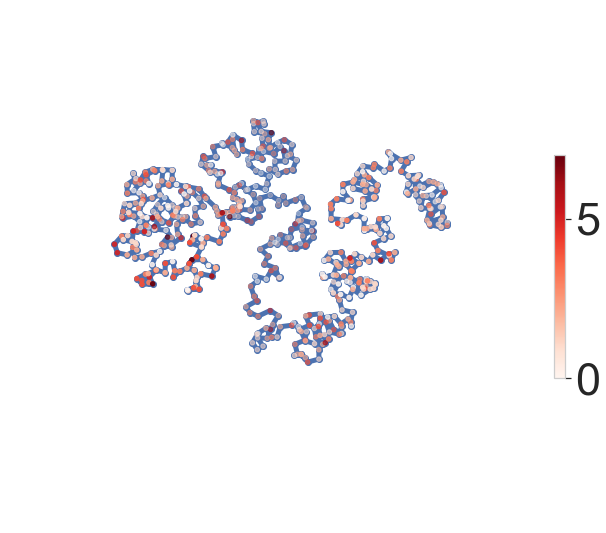

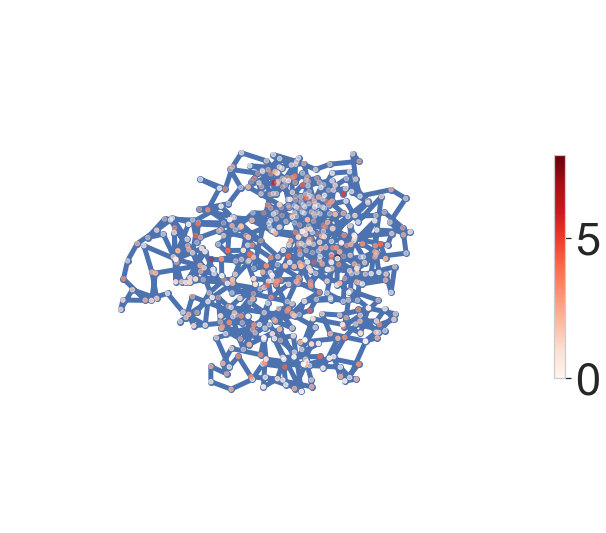

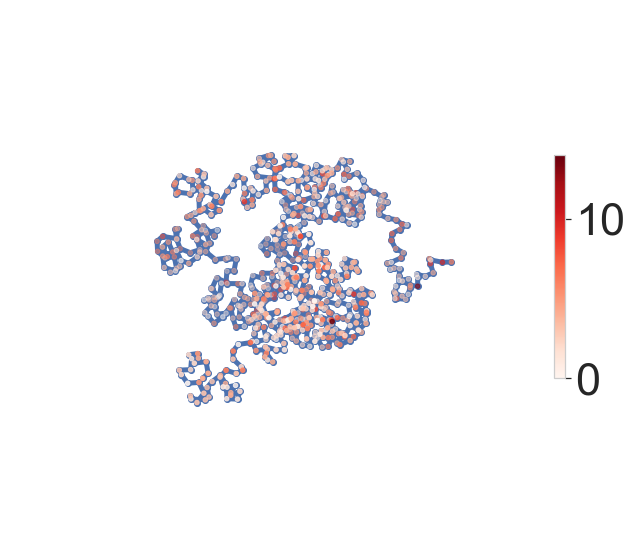

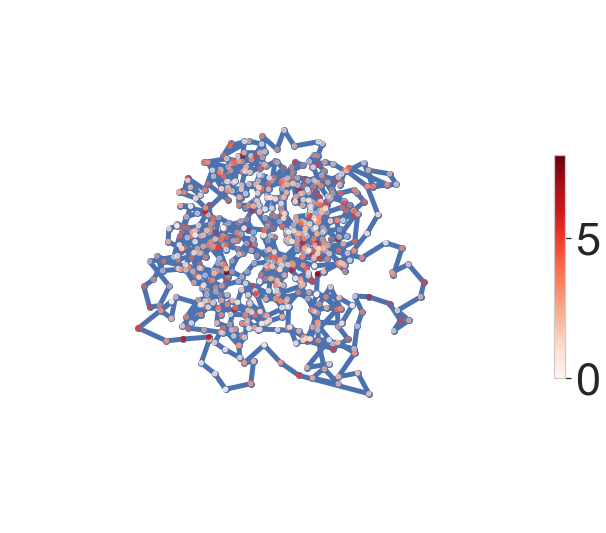

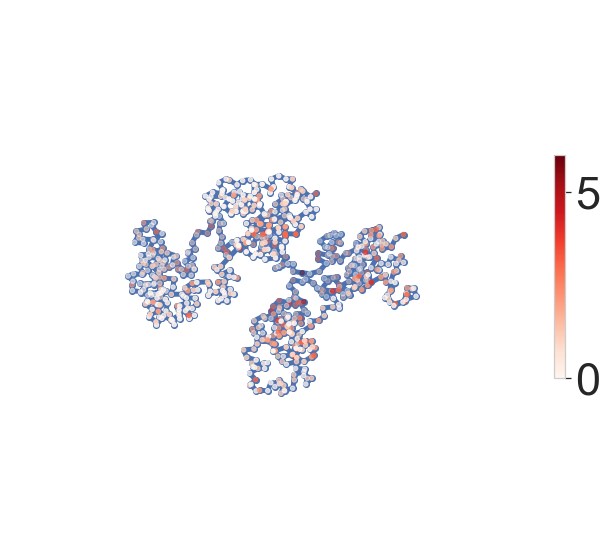

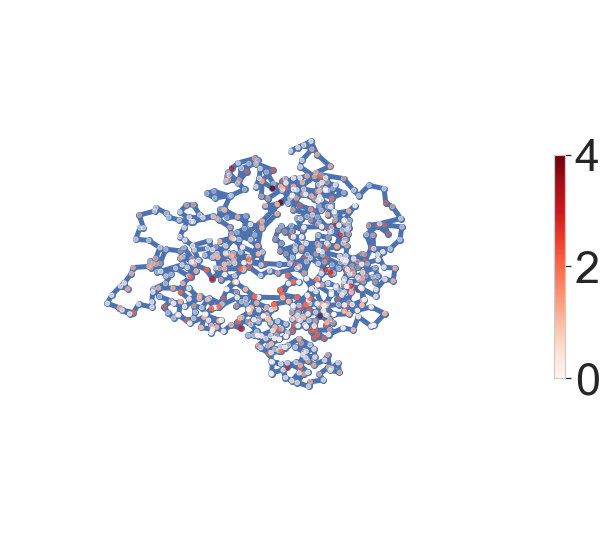

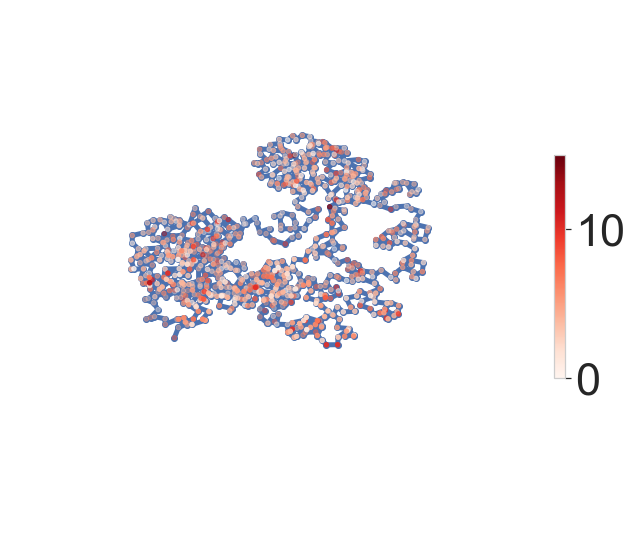

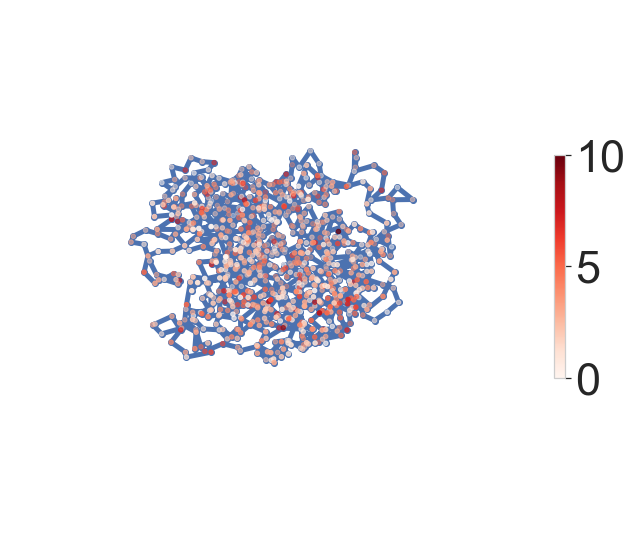

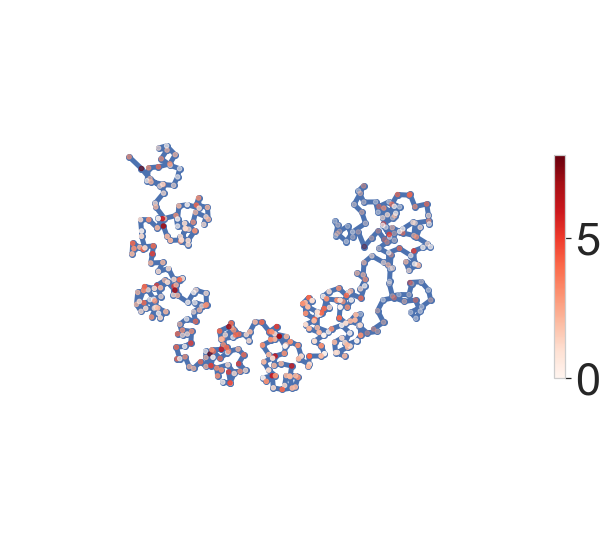

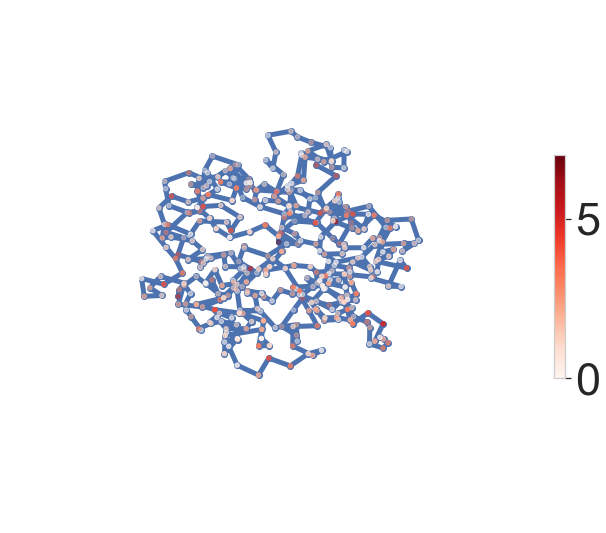

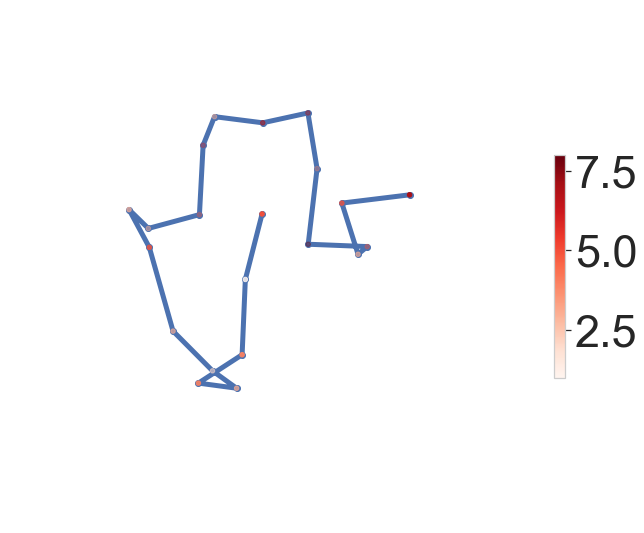

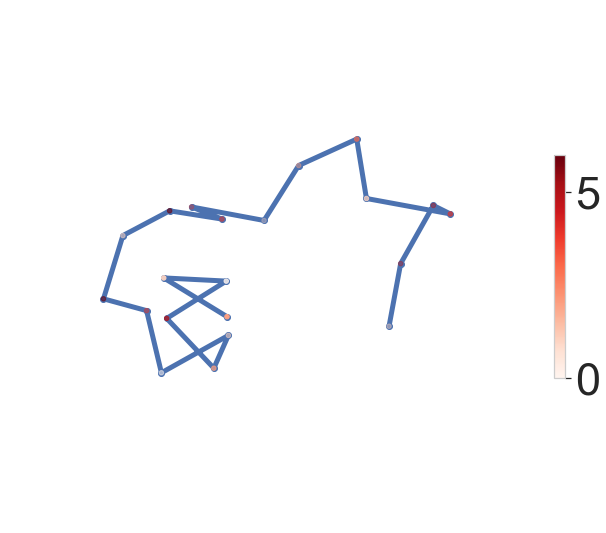

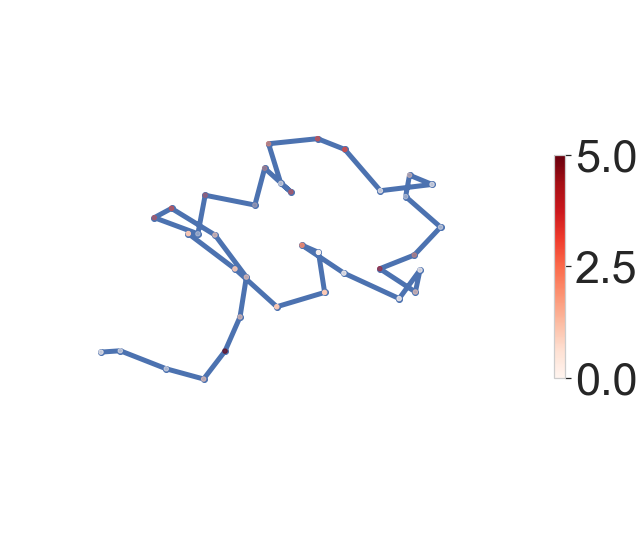

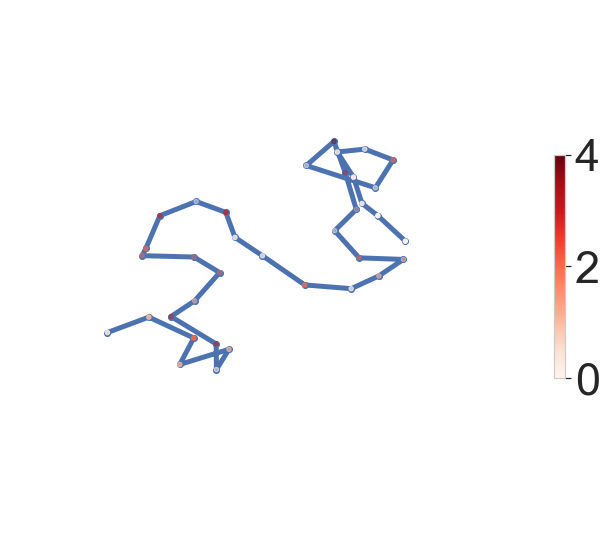

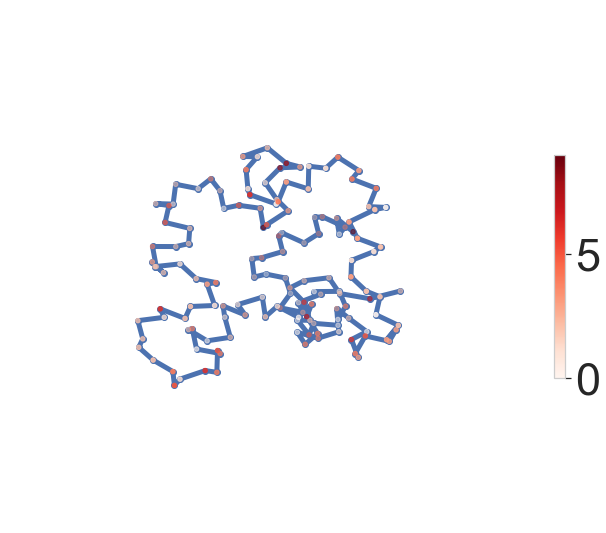

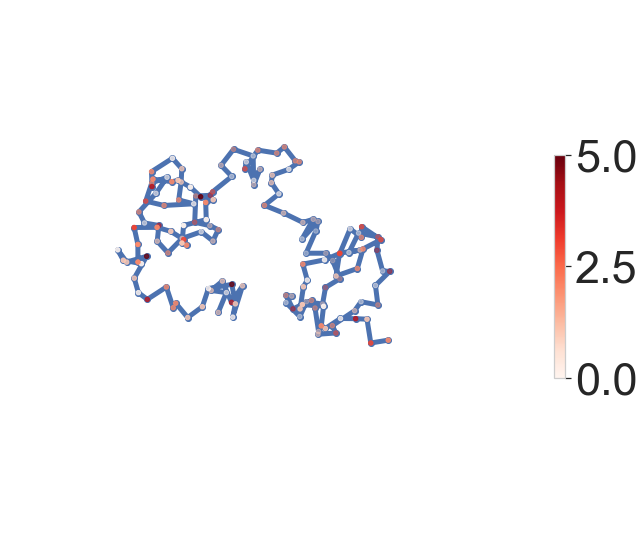

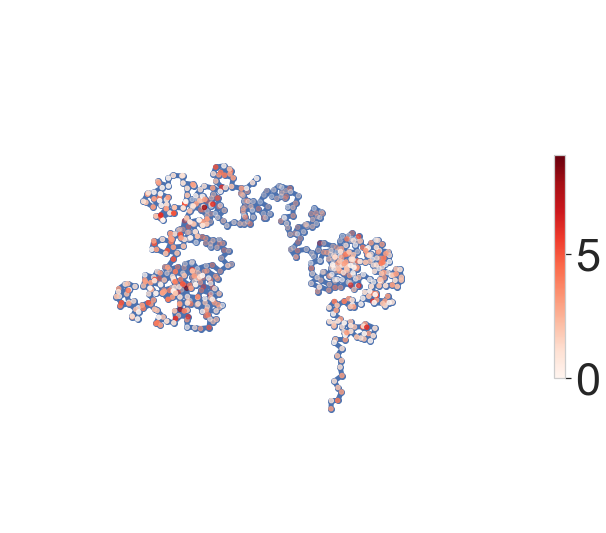

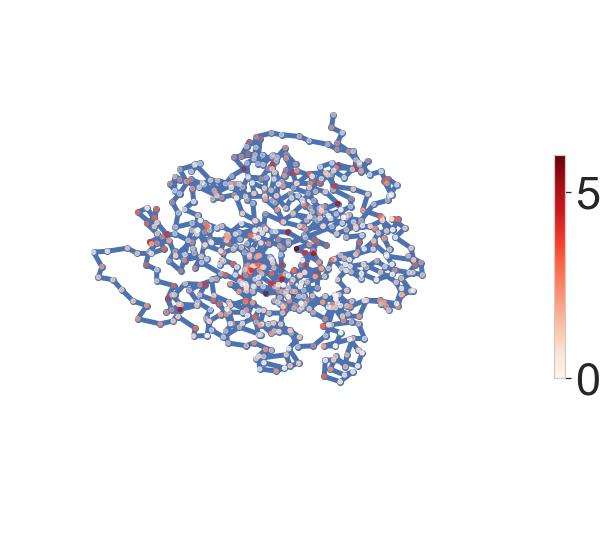

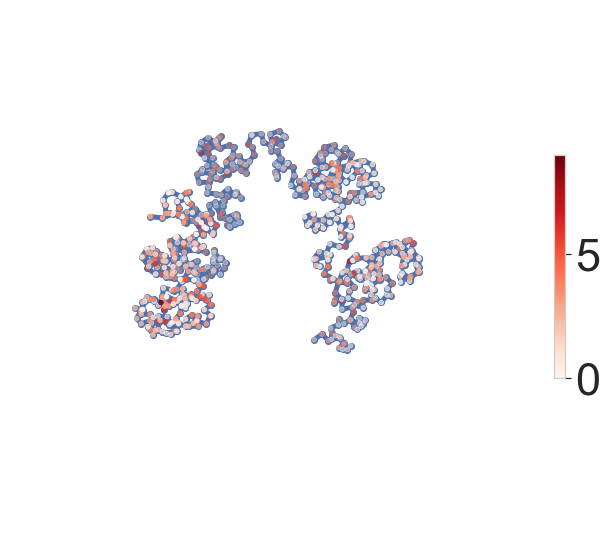

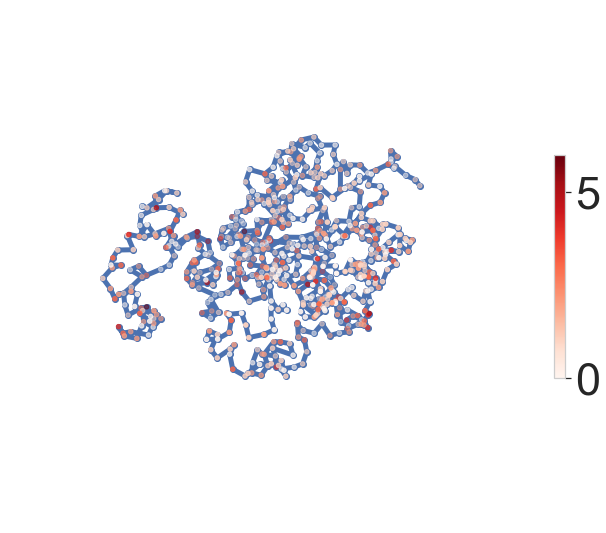

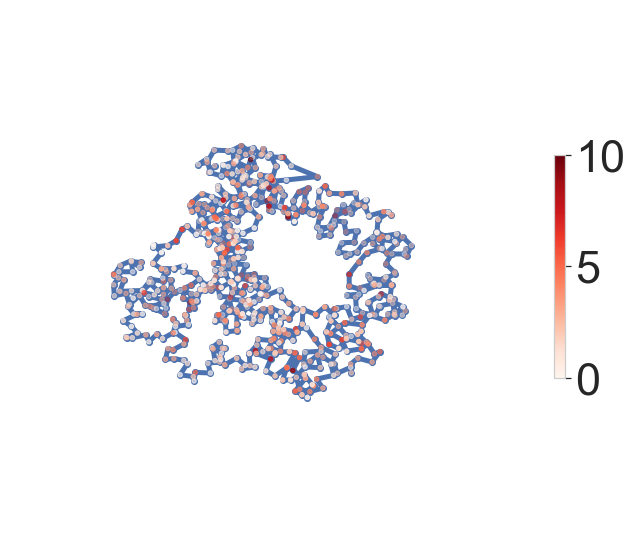

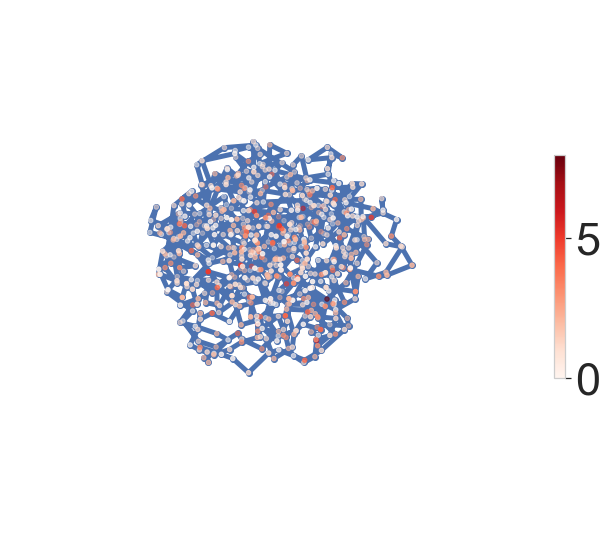

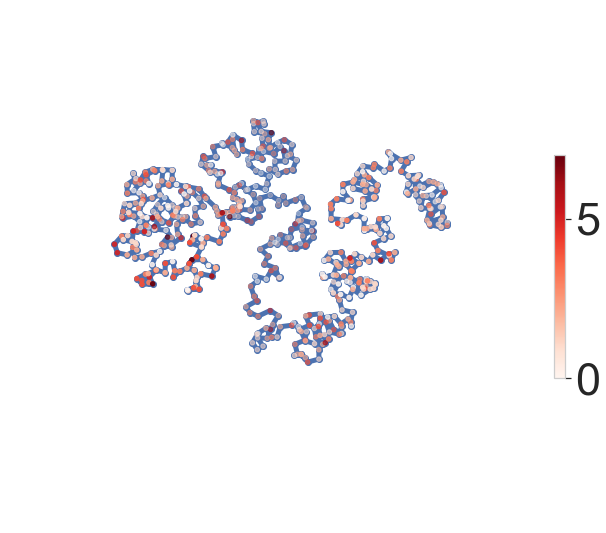

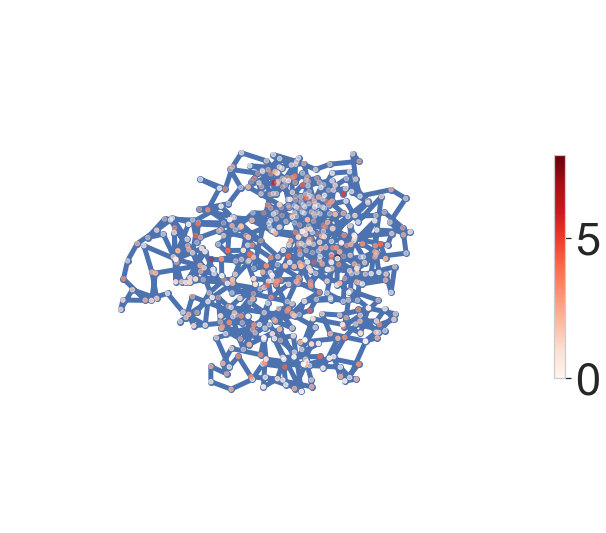

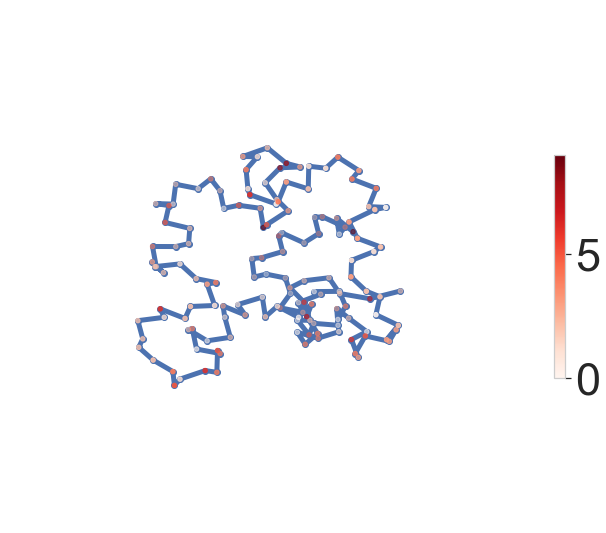

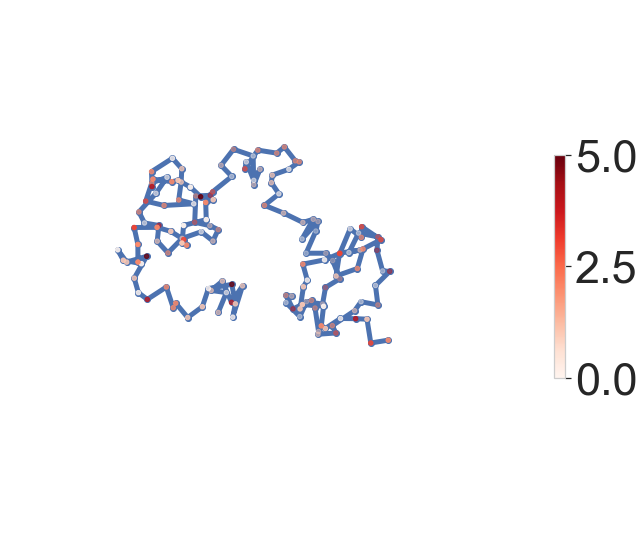

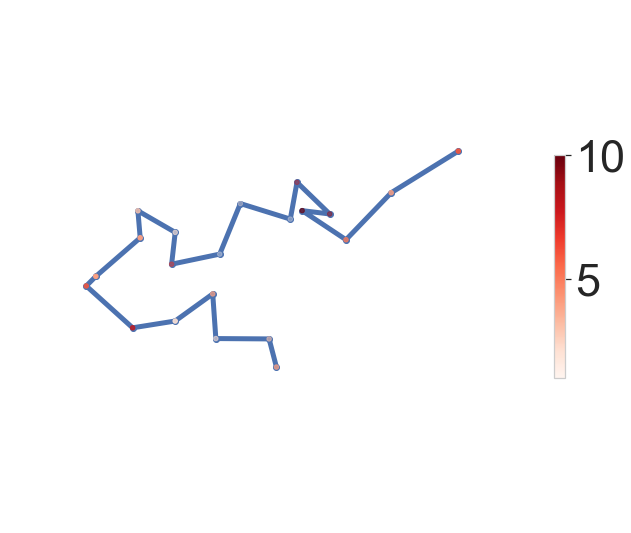

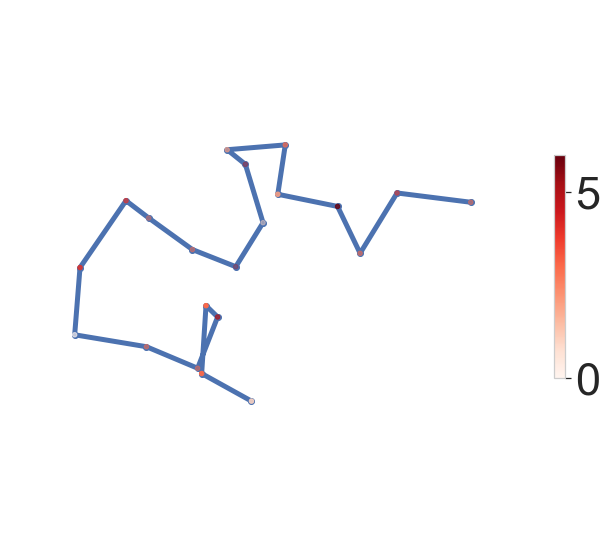

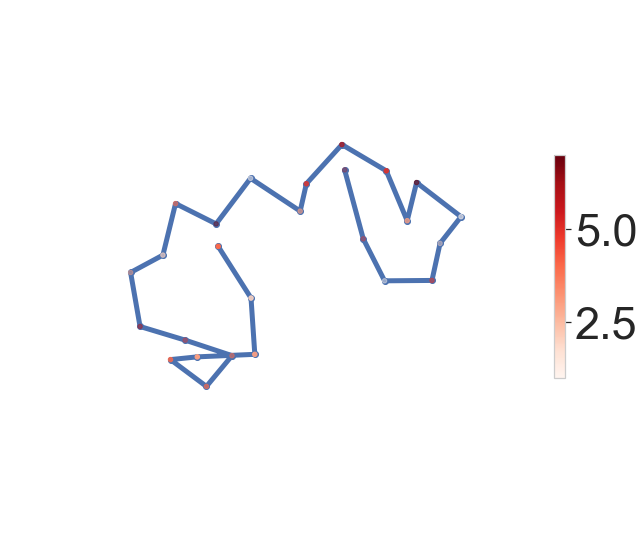

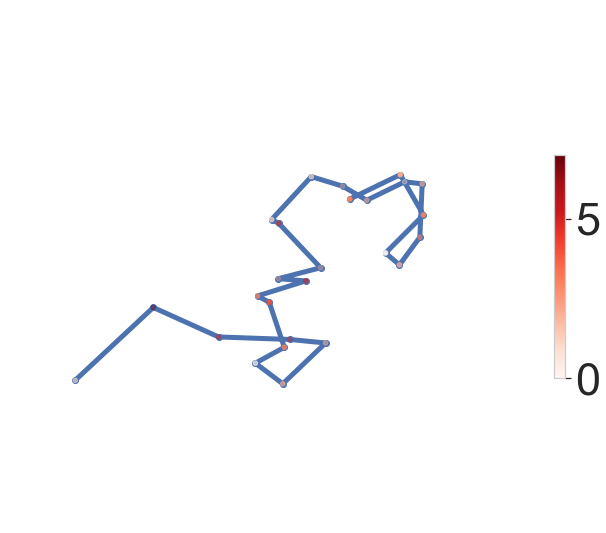

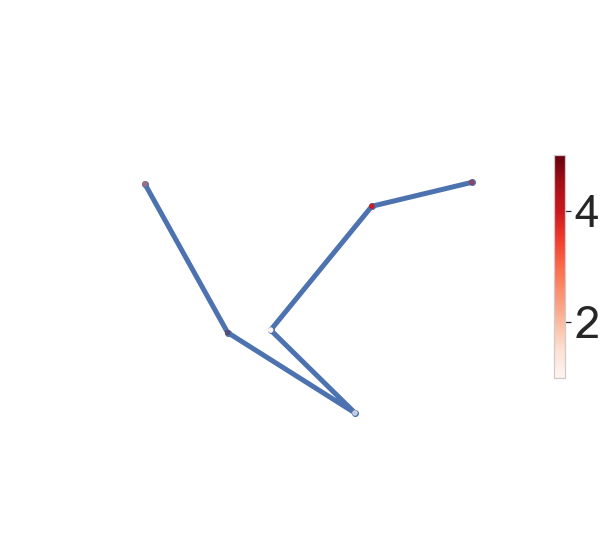

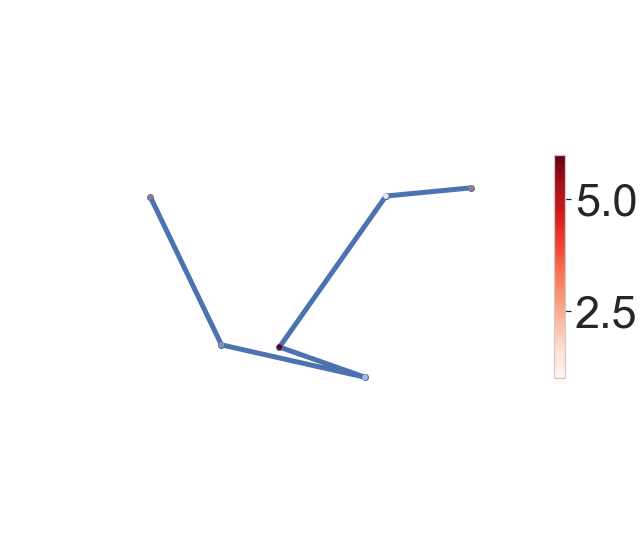

In [19]:
for key in _ranges.keys():
    _range, _points = _ranges[key], np.array(points[key])
    scores = get_seq_score(CTCF_path, _range[0], _range[1], _range[2])
    show(_points, scores, 'CTCF({})'.format(key))
    _range, _points = _ranges[key], np.array(points['Hex_{}'.format(key)])
    scores = get_seq_score(Hex_CTCF_path, _range[0], _range[1], _range[2])
    show(_points, scores, 'CTCF after Hex5({})'.format(key))